In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pydicom as dicom
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score

2024-04-17 20:04:29.607047: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 20:04:29.607195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 20:04:29.824290: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
df = df.rename(columns={'anatom_site_general_challenge': 'site'})

# Step 2: Display Initial Data
print(df.head())


     image_name  patient_id     sex  age_approx             site diagnosis  \
0  ISIC_2637011  IP_7279968    male        45.0        head/neck   unknown   
1  ISIC_0015719  IP_3075186  female        45.0  upper extremity   unknown   
2  ISIC_0052212  IP_2842074  female        50.0  lower extremity     nevus   
3  ISIC_0068279  IP_6890425  female        45.0        head/neck   unknown   
4  ISIC_0074268  IP_8723313  female        55.0  upper extremity   unknown   

  benign_malignant  target  
0           benign       0  
1           benign       0  
2           benign       0  
3           benign       0  
4           benign       0  


In [5]:
# Step 3: Data Balancing and Splitting
# Count the number of samples for each class
count_0 = df[df.target == 0].shape[0]
count_1 = df[df.target == 1].shape[0]

# Sample without replacement for each class
s0 = df[df.target == 0].sample(min(500, count_0), random_state=1).index
s1 = df[df.target == 1].sample(min(600, count_1), random_state=1).index

balanced_indices = s0.union(s1)
balanced_df = df.loc[balanced_indices]

train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

y_train = train_df['target'].values.astype(int)
y_test = test_df['target'].values.astype(int)

# Convert target column to string type
train_df['target'] = train_df['target'].astype(str)
test_df['target'] = test_df['target'].astype(str)


In [6]:
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
import pydicom as dicom

# Load the pre-trained VGG16 model (excluding the top layers)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


def preprocess_image(dcm_path):
    ds = dicom.dcmread(dcm_path)
    pixels = ds.pixel_array
    pixels = np.expand_dims(pixels, axis=-1)  # Add channel dimension
    pixels = np.repeat(pixels, 3, axis=-1)  # Convert to 3-channel image
    pixels = np.resize(pixels, (224, 224, 3))  # Resize to VGG16 input size
    x = np.expand_dims(pixels, axis=0)
    x = preprocess_input(x)
    return x.squeeze()  # Remove extra dimension


# Load and preprocess images for training
train_images = []
for img_name in train_df['image_name']:
    dcm_path = '/kaggle/input/siim-isic-melanoma-classification/train/' + img_name + '.dcm'
    preprocessed_img = preprocess_image(dcm_path)
    train_images.append(preprocessed_img)

# Convert list of preprocessed images to numpy array
train_images = np.array(train_images)

# Load and preprocess images for testing
test_images = []
for img_name in test_df['image_name']:
    dcm_path = '/kaggle/input/siim-isic-melanoma-classification/train/' + img_name + '.dcm'
    preprocessed_img = preprocess_image(dcm_path)
    test_images.append(preprocessed_img)

# Convert list of preprocessed images to numpy array
test_images = np.array(test_images)

/opt/conda/lib/python3.10/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '"1.2.840.10008.5.1.4.1.1.77.1.4"'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


In [7]:
print("Shape of train_images:", train_images.shape)


Shape of train_images: (867, 224, 224, 3)


In [8]:
# Extract features using the pre-trained VGG16 model
train_features = vgg_model.predict(train_images)
test_features = vgg_model.predict(test_images)


28/28 ━━━━━━━━━━━━━━━━━━━━ 263s 9s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 60s 9s/step


In [9]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

# Define a classifier model
classifier_model = Sequential()
classifier_model.add(Flatten(input_shape=train_features.shape[1:]))
classifier_model.add(Dense(256, activation='relu'))
classifier_model.add(Dropout(0.5))
classifier_model.add(Dense(1, activation='sigmoid'))

# Compile the model
classifier_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the classifier model
history = classifier_model.fit(train_features, y_train, epochs=10, batch_size=32, validation_split=0.2)

classifier_model.save('your_model.h5')


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.5960 - loss: 4.2011 - val_accuracy: 0.7069 - val_loss: 1.0048
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6900 - loss: 1.3582 - val_accuracy: 0.7356 - val_loss: 0.7276
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7293 - loss: 0.6593 - val_accuracy: 0.7644 - val_loss: 0.6194
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7722 - loss: 0.5340 - val_accuracy: 0.7471 - val_loss: 0.5226
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7764 - loss: 0.4531 - val_accuracy: 0.7644 - val_loss: 0.5242
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7947 - loss: 0.4634 - val_accuracy: 0.7414 - val_loss: 0.5692
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7997 - loss: 0.4140 - val_accuracy: 0.7701 - val_loss: 0.5350
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7933 - loss: 0.4356 - val_accuracy: 0.7701 - v

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


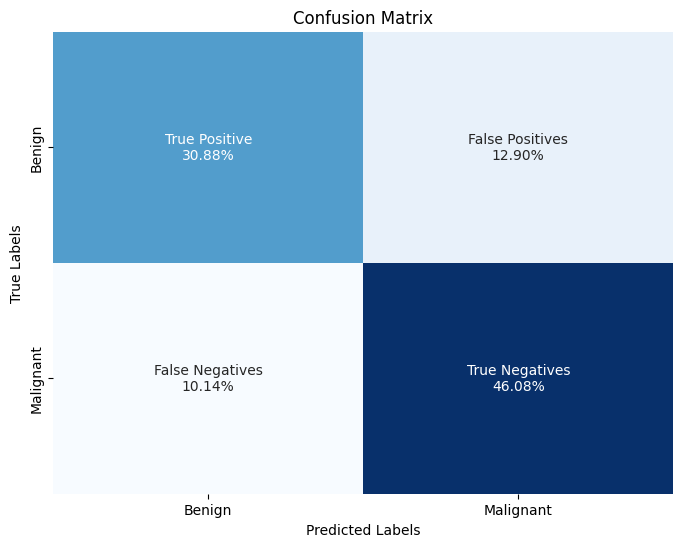

Accuracy: 0.7695852534562212
F1 Score: 0.8
Precision Score: 0.78125
Recall Score: 0.819672131147541


In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict probabilities on test set
y_prob = classifier_model.predict(test_features)

# Convert probabilities to class labels based on a threshold (0.5 for binary classification)
y_pred = np.where(y_prob > 0.5, 1, 0)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)


names = ['True Positive', 'False Positives', 'False Negatives', 'True Negatives']
counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
labels = np.asarray(labels).reshape(2,2)
ticklabels = ['Benign', 'Malignant']

# Plot confusion matrix as a heatmap
names = ['True Positive', 'False Positives', 'False Negatives', 'True Negatives']
plt.figure(figsize=(8, 6))
sns.heatmap(cm,  annot=labels, fmt='', cmap='Blues', xticklabels=ticklabels, yticklabels=ticklabels, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
#f1 score
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision Score:", precision)
print("Recall Score:", recall)




7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


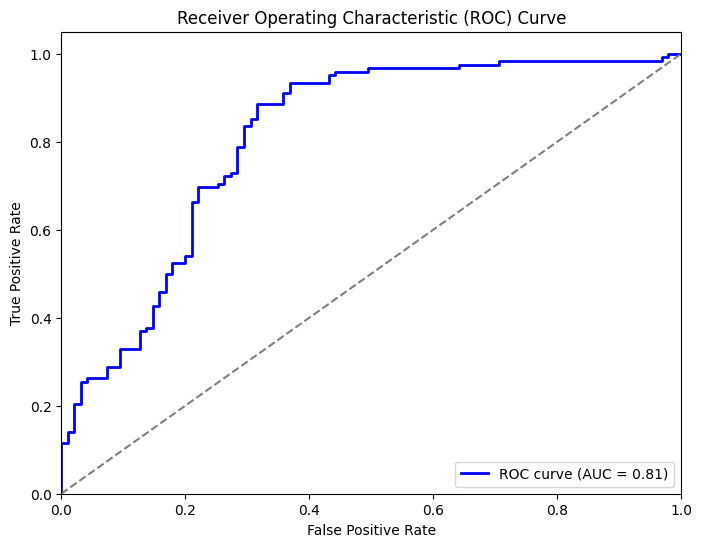

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities on the test set
y_prob = classifier_model.predict(test_features)

# Calculate fpr, tpr, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the area under the ROC curve (AUC)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [13]:
import os
import numpy as np
import pydicom as dicom
from keras.preprocessing import image

def preprocess_image(dcm_path):
    ds = dicom.dcmread(dcm_path)
    pixels = ds.pixel_array
    pixels = np.expand_dims(pixels, axis=-1)  # Add channel dimension
    pixels = np.repeat(pixels, 3, axis=-1)  # Convert to 3-channel image
    pixels = np.resize(pixels, (224, 224, 3))  # Resize to VGG16 input size
    x = np.expand_dims(pixels, axis=0)
    x = x.astype('float32')
    x = x / 255.0  # Normalize the pixel values
    return x

# Path to the new DICOM image
new_dcm_path = '/kaggle/input/siim-isic-melanoma-classification/test/ISIC_0052060.dcm'

# Preprocess the new DICOM image
new_image = preprocess_image(new_dcm_path)

# Extract features using the pre-trained VGG16 model
new_image_features = vgg_model.predict(new_image)

# Predict probability of malignancy
prob_malignant = classifier_model.predict(new_image_features)[0][0]

# Define a threshold for classification
threshold = 1  # You can adjust this threshold based on your requirements

# Classify based on threshold
if prob_malignant < threshold:
    prediction = 'Benign'
else:
    prediction = 'Malignant'

print(f"The DICOM image is predicted to be: {prediction} (Probability: {prob_malignant})")



/opt/conda/lib/python3.10/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '"1.2.840.10008.5.1.4.1.1.77.1.4"'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
The DICOM image is predicted to be: Benign (Probability: 0.6981351971626282)


In [ ]:
import os
import numpy as np
from keras.preprocessing import image

def preprocess_jpeg_image(image_path):
    # Load and preprocess the JPEG image using Keras
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float32') / 255.0  # Normalize pixel values
    return img_array

# Path to the new JPEG image
new_jpeg_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/test/ISIC_0058510.jpg'

# Preprocess the new JPEG image
new_image = preprocess_jpeg_image(new_jpeg_path)

# Extract features using the pre-trained VGG16 model
new_image_features = vgg_model.predict(new_image)

# Predict probability of malignancy
prob_malignant = classifier_model.predict(new_image_features)[0][0]

# Define a threshold for classification
threshold = 0.5  # You can adjust this threshold based on your requirements

# Classify based on threshold
if prob_malignant < threshold:
    prediction = 'Benign'
else:
    prediction = 'Malignant'

print(f"The JPEG image is predicted to be: {prediction} (Probability: {prob_malignant})")
